In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch import nn
import torch.optim as optim
import torchvision
#pip install torchvision
from torchvision import transforms, models, datasets
import imageio
import time
import warnings
import random
import sys
import copy
import json
from PIL import Image

d:\anaconda\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_dir = './采集的图片/绿色版'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
train_dir

'./采集的图片/绿色版/train'

In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(45),#随机旋转，-45到45度之间随机选
        transforms.CenterCrop(160),#从中心开始裁剪
        transforms.RandomHorizontalFlip(p=0.5),#随机水平翻转 选择一个概率概率，p为概率
        transforms.RandomVerticalFlip(p=0.5),#随机垂直翻转
        transforms.ToTensor(),#把数据转换成tensor格式
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])#均值，标准差
    ]),
    'test': transforms.Compose([transforms.Resize(160),          #测试时是随机的不知道大小的图片，所以加了一个resize.
        transforms.CenterCrop(160),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [4]:
batch_size = 16

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
class_names

['0', '1']

In [5]:

with open('./采集的图片/Readme.json', 'r',encoding='UTF-8') as f:
        Readme=json.load(f)

Readme


{'0': '合格', '1': '不合格'}

In [6]:
def im_convert(tensor):
    """ 展示数据"""
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

d:\anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 19981 (\N{CJK UNIFIED IDEOGRAPH-4E0D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 21512 (\N{CJK UNIFIED IDEOGRAPH-5408}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\anaconda\envs\pytorch\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26684 (\N{CJK UNIFIED IDEOGRAPH-683C}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


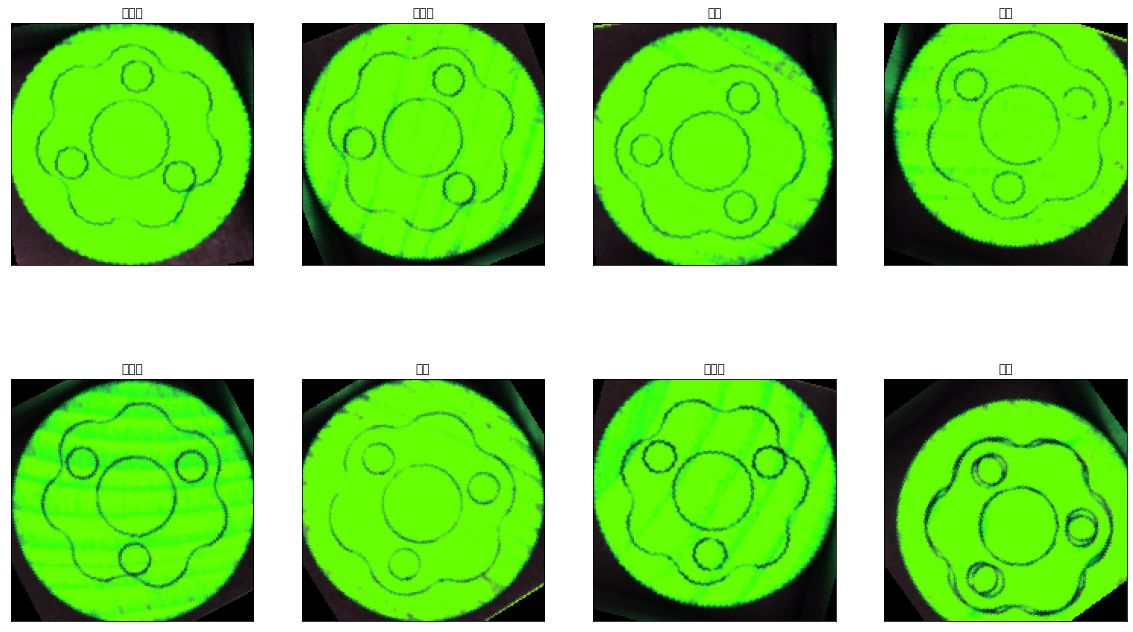

In [7]:
fig=plt.figure(figsize=(20, 12))
columns = 4
rows = 2

dataiter = iter(dataloaders['train'])
inputs, classes = dataiter.next()

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    ax.set_title(Readme[str(int(class_names[classes[idx]]))])
    plt.imshow(im_convert(inputs[idx]))
plt.show()

In [8]:
model_name = 'densenet'  #可选的比较多 ['resnet', 'alexnet', 'vgg', 'squeezenet', 'densenet', 'inception']
#是否用人家训练好的特征来做
feature_extract = True 

In [9]:
# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


CUDA is available!  Training on GPU ...


In [10]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [11]:
model_ft = models.densenet201()
model_ft.classifier

Linear(in_features=1920, out_features=1000, bias=True)

In [14]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # 选择合适的模型，不同模型的初始化方法稍微有点区别
    model_ft = None
    input_size = 0

    if model_name == "densenet":
        """ Resnet152
        """
        model_ft = models.densenet201(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier= nn.Sequential(nn.Linear(num_ftrs, 2),#自己的实际数据，更改。
                                   nn.LogSoftmax(dim=1))
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [61]:
model_ft, input_size = initialize_model(model_name, 2, feature_extract, use_pretrained=True)

#GPU计算
model_ft = model_ft.to(device)

# 模型保存
filename='checkpoint.pth'

# 是否训练所有层
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

Params to learn:
	 classifier.0.weight
	 classifier.0.bias


In [16]:
model_ft

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [60]:
# 优化器设置
#optimizer_ft = optim.SGD(params_to_update,lr=0.003,momentum=0.8,nesterov=True,weight_decay=0.1)
#optimizer_ft= torch.optim.RMSprop(params_to_update,lr=0.01,alpha=0.9)
optimizer_ft = optim.Adam(params_to_update, lr=0.005)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
criterion = nn.NLLLoss()


In [18]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=26, is_inception=False,filename=filename):
    since = time.time()
    best_acc = 0
    """
    checkpoint = torch.load(filename)
    best_acc = checkpoint['best_acc']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    model.class_to_idx = checkpoint['mapping']
    """
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []
    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:#resnet执行的是这里
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),
                }
                torch.save(state, filename)
            if phase == 'test':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs 

In [62]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=16, is_inception=(model_name=="inception"))


Epoch 0/15
----------
Time elapsed 0m 1s
train Loss: 0.7281 Acc: 0.4324
Time elapsed 0m 2s
test Loss: 0.7232 Acc: 0.4079
Optimizer learning rate : 0.0050000

Epoch 1/15
----------
Time elapsed 0m 3s
train Loss: 0.7173 Acc: 0.5000
Time elapsed 0m 4s
test Loss: 0.7622 Acc: 0.4211
Optimizer learning rate : 0.0050000

Epoch 2/15
----------
Time elapsed 0m 5s
train Loss: 0.7105 Acc: 0.4910
Time elapsed 0m 6s
test Loss: 0.7700 Acc: 0.3684
Optimizer learning rate : 0.0050000

Epoch 3/15
----------
Time elapsed 0m 7s
train Loss: 0.7297 Acc: 0.4459
Time elapsed 0m 7s
test Loss: 0.7719 Acc: 0.3947
Optimizer learning rate : 0.0050000

Epoch 4/15
----------
Time elapsed 0m 8s
train Loss: 0.7186 Acc: 0.4865
Time elapsed 0m 9s
test Loss: 0.7748 Acc: 0.3947
Optimizer learning rate : 0.0050000

Epoch 5/15
----------
Time elapsed 0m 10s
train Loss: 0.7256 Acc: 0.4550
Time elapsed 0m 10s
test Loss: 0.7600 Acc: 0.4211
Optimizer learning rate : 0.0050000

Epoch 6/15
----------
Time elapsed 0m 12s
train Lo

In [63]:

mean_acc=sum(val_acc_history)/len(val_acc_history)

val_acc_history



[tensor(0.4079, device='cuda:0', dtype=torch.float64),
 tensor(0.4211, device='cuda:0', dtype=torch.float64),
 tensor(0.3684, device='cuda:0', dtype=torch.float64),
 tensor(0.3947, device='cuda:0', dtype=torch.float64),
 tensor(0.3947, device='cuda:0', dtype=torch.float64),
 tensor(0.4211, device='cuda:0', dtype=torch.float64),
 tensor(0.4079, device='cuda:0', dtype=torch.float64),
 tensor(0.4211, device='cuda:0', dtype=torch.float64),
 tensor(0.4342, device='cuda:0', dtype=torch.float64),
 tensor(0.4079, device='cuda:0', dtype=torch.float64),
 tensor(0.4211, device='cuda:0', dtype=torch.float64),
 tensor(0.4079, device='cuda:0', dtype=torch.float64),
 tensor(0.4079, device='cuda:0', dtype=torch.float64),
 tensor(0.4211, device='cuda:0', dtype=torch.float64),
 tensor(0.4079, device='cuda:0', dtype=torch.float64),
 tensor(0.4079, device='cuda:0', dtype=torch.float64)]

In [64]:
mean_loss=sum(valid_losses)/len(valid_losses)
valid_losses

[0.7232021783527575,
 0.762207097128818,
 0.7700069954520777,
 0.7719161039904544,
 0.774821096344998,
 0.759966812635723,
 0.7662203845224882,
 0.7723486674459357,
 0.7612490622620833,
 0.7629863870771307,
 0.7586802526524192,
 0.764296271299061,
 0.7676327008950082,
 0.7660336243478876,
 0.7666682977425424,
 0.7678578746946234]

In [52]:
for param in model_ft.parameters():
    param.requires_grad = True
#optimizer = optim.Adam(params_to_update, lr=0.01)
optimizer= optim.SGD(params_to_update,lr=0.003,momentum=0.8,nesterov=True,weight_decay=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7)
criterion = nn.NLLLoss()

In [54]:
model_ft, input_size = initialize_model(model_name, 2, feature_extract, use_pretrained=True)

# GPU模式
model_ft = model_ft.to(device)

# Load the checkpoint

checkpoint = torch.load(filename)
best_acc = checkpoint['best_acc']
model_ft.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])
#model_ft.class_to_idx = checkpoint['mapping']

In [55]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs  = train_model(model_ft, dataloaders, criterion, optimizer, num_epochs=40, is_inception=(model_name=="inception"))

Epoch 0/39
----------
Time elapsed 0m 1s
train Loss: 0.3627 Acc: 0.8559
Time elapsed 0m 2s
test Loss: 0.3872 Acc: 0.8684
Optimizer learning rate : 0.0030000

Epoch 1/39
----------
Time elapsed 0m 3s
train Loss: 0.2987 Acc: 0.9009
Time elapsed 0m 4s
test Loss: 0.3928 Acc: 0.8421
Optimizer learning rate : 0.0030000

Epoch 2/39
----------
Time elapsed 0m 5s
train Loss: 0.3358 Acc: 0.8559
Time elapsed 0m 5s
test Loss: 0.3841 Acc: 0.8553
Optimizer learning rate : 0.0030000

Epoch 3/39
----------
Time elapsed 0m 6s
train Loss: 0.3684 Acc: 0.8739
Time elapsed 0m 7s
test Loss: 0.3894 Acc: 0.8421
Optimizer learning rate : 0.0030000

Epoch 4/39
----------
Time elapsed 0m 8s
train Loss: 0.3003 Acc: 0.9144
Time elapsed 0m 8s
test Loss: 0.3947 Acc: 0.8553
Optimizer learning rate : 0.0030000

Epoch 5/39
----------
Time elapsed 0m 10s
train Loss: 0.3211 Acc: 0.8919
Time elapsed 0m 10s
test Loss: 0.3904 Acc: 0.8553
Optimizer learning rate : 0.0030000

Epoch 6/39
----------
Time elapsed 0m 11s
train Lo

In [56]:
valid_losses

[0.38721223724515813,
 0.39276499654117386,
 0.3841294473723361,
 0.38942834891771017,
 0.39467718099292953,
 0.39040786969034297,
 0.39590881215898616,
 0.4059661438590602,
 0.3895411146314521,
 0.3857240080833435,
 0.38489369342201635,
 0.3895461025990938,
 0.38439786120464925,
 0.37678178517442,
 0.38539560217606394,
 0.39197152068740443,
 0.3883727804610604,
 0.3842146475064127,
 0.3796463200920506,
 0.3724458013710223,
 0.3735393081840716,
 0.3794405774066323,
 0.3792813561464611,
 0.3791355443628211,
 0.3757066601201108,
 0.37645384669303894,
 0.3786328136920929,
 0.3831200850637336,
 0.3859797371061225,
 0.3823176057715165,
 0.38840124952165705,
 0.3762816378944798,
 0.37808939657713236,
 0.374231722794081,
 0.38238259522538437,
 0.374980313213248,
 0.37655967787692424,
 0.3835098868922183,
 0.3831960009901147,
 0.391168192813271]

In [84]:
def save_load_model(model):
    '''saving and loading models'''
    model.load_state_dict(torch.load("../../data/Lenet-5.pth")) # 加载模型
    model.eval() # 将网络设置为评估模式
 
    # state_dict:返回一个字典,保存着module的所有状态,参数和persistent buffers都会包含在字典中,字典的key就是参数和buffer的names
    print("model state dict keys:", model.state_dict().keys())
    print("model type:", type(model)) # model type: <class 'pytorch.lenet5.test_lenet5_mnist.LeNet5'>
    print("model state dict type:", type(model.state_dict())) # model state dict type: <class 'collections.OrderedDict'>
 
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    print_state_dict(model.state_dict(), optimizer.state_dict())
    torch.save(model.state_dict(), "../../data/Lenet-5_parameters.pth") # 保存训练模型的参数,为以后恢复模型提供最大的灵活性

In [85]:
def save_load_checkpoint(model):
    '''saving & loading a general checkpoint for inference and/or resuming training'''
    path = "../../data/Lenet-5_parameters.tar"
    model.load_state_dict(torch.load("../../data/Lenet-5.pth")) # 加载模型
    optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
    torch.save({
                'epoch': 5,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, path)
 
    checkpoint = torch.load(path)
    model2 = LeNet5(n_classes=10).to('cpu') # 实例化一个LeNet5网络对象
    model2.load_state_dict(checkpoint['model_state_dict'])
    optimizer2 = torch.optim.SGD(params=model2.parameters(), lr=0.1)
    optimizer2.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print("epoch:", epoch)
    model.eval() # 将网络设置为评估模式
    #model.train() # 恢复训练,将网络设置为训练模式
 
    print_state_dict(model2.state_dict(), optimizer2.state_dict())





In [86]:
def process_image(image_path):
    # 读取测试数据
    img = Image.open(image_path)
    # Resize,thumbnail方法只能进行缩小，所以进行了判断
    if img.size[0] > img.size[1]:
        img.thumbnail((10000, 256))
    else:
        img.thumbnail((256, 10000))
    # Crop操作
    left_margin = (img.width-224)/2
    bottom_margin = (img.height-224)/2
    right_margin = left_margin + 224
    top_margin = bottom_margin + 224
    img = img.crop((left_margin, bottom_margin, right_margin,   
                      top_margin))
    # 相同的预处理方法
    img = np.array(img)/255
    mean = np.array([0.485, 0.456, 0.406]) #provided mean
    std = np.array([0.229, 0.224, 0.225]) #provided std
    img = (img - mean)/std
    
    # 注意颜色通道应该放在第一个位置
    img = img.transpose((2, 0, 1))
    
    return img

In [87]:
def imshow(image, ax=None, title=None):
    """展示数据"""
    if ax is None:
        fig, ax = plt.subplots()
    
    # 颜色通道还原
    image = np.array(image).transpose((1, 2, 0))
    
    # 预处理还原
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    ax.set_title(title)
    
    return ax

In [88]:
image_path = 'C://Users//pandas//Videos//image_1234567.jpg'
img = process_image(image_path)
imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'C://Users//pandas//Videos//image_1234567.jpg'

In [29]:
img.shape

(3, 224, 224)

In [33]:
# 得到一个batch的测试数据
dataiter = iter(dataloaders['test'])
images, labels = dataiter.next()

model_ft.eval()

if train_on_gpu:
    output = model_ft(images.cuda())
else:
    output = model_ft(images)

In [34]:
output.shape

torch.Size([8, 2])

In [35]:
_, preds_tensor = torch.max(output, 1)

preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())
preds

array([1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

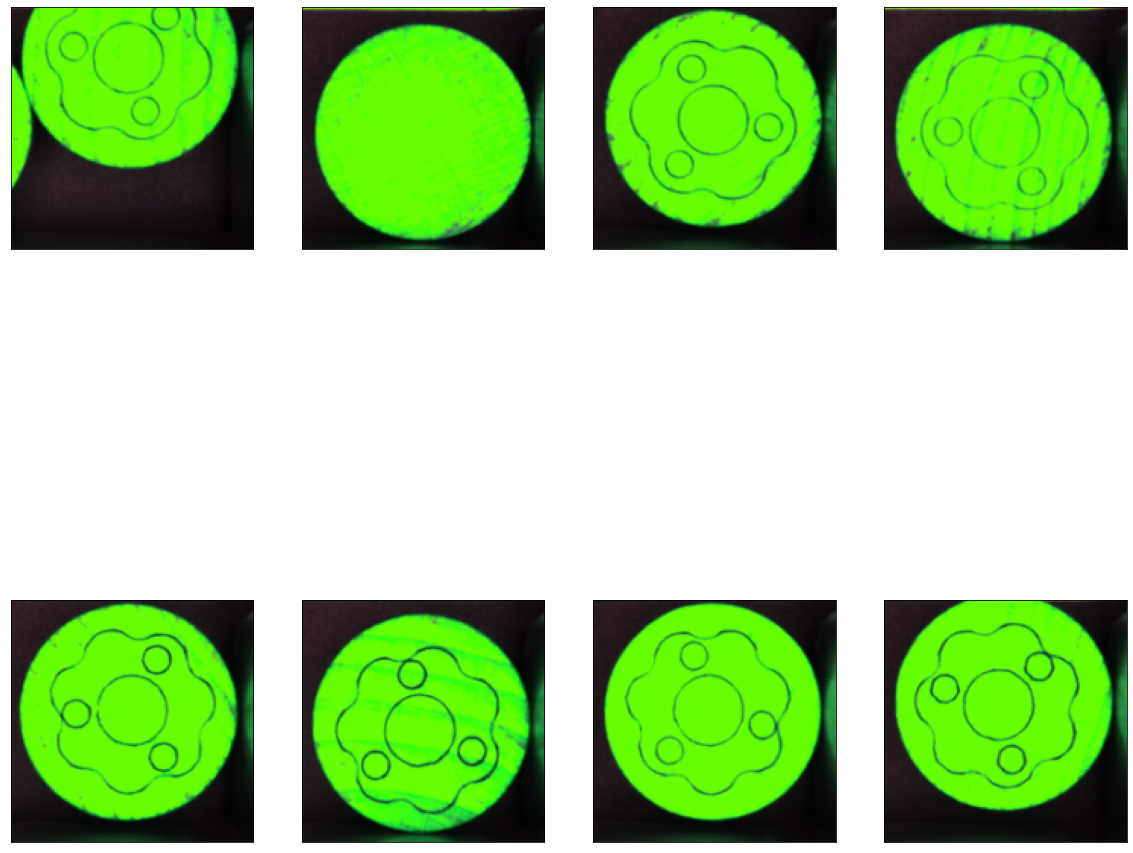

In [36]:
fig=plt.figure(figsize=(20, 20))
columns =4
rows = 2

for idx in range (columns*rows):
    ax = fig.add_subplot(rows, columns, idx+1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    
plt.show()